# Synapses

Synapses model the temporal dynamics of neural connections in `brainpy.state`. This document explains
how synapses work, what models are available, and how to use them effectively.

## Overview

Synapses provide temporal filtering of spike trains, transforming discrete spikes into continuous currents or conductances. They model:

- **Postsynaptic potentials** (PSPs)
- **Temporal integration** of spike trains
- **Synaptic dynamics** (rise and decay)

In BrainPy's architecture, synapses are part of the projection system:

```text
Spikes → [Connectivity] → [Synapse] → [Output] → Neurons
                              ↑
                      Temporal filtering
```


## Basic Usage

### Creating Synapses

Synapses are typically created as part of projections:

In [1]:
import brainstate
import braintools
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt

import brainpy

In [2]:
# Create neurons for demonstration
neurons = brainpy.state.LIF(50, V_rest=-65 * u.mV, V_th=-50 * u.mV, tau=10 * u.ms)

# Create synapse descriptor
syn = brainpy.state.Expon(
    in_size=100,  # Number of synapses
    tau=5. * u.ms  # Time constant
)

# Use in projection
projection = brainpy.state.AlignPostProj(
    comm=brainstate.nn.EventFixedProb(100, 50, 0.1, 0.5),
    syn=syn,  # Synapse here
    out=brainpy.state.CUBA(),
    post=neurons
)

### Synapse Lifecycle

1. **Creation**: Define synapse with `()` method
2. **Integration**: Include in projection
3. **Update**: Called automatically by projection
4. **Access**: Read synaptic variables as needed

In [5]:
# Example presynaptic spikes
presynaptic_spikes = jnp.zeros(100)  # 100 presynaptic neurons

projection = brainpy.state.AlignPostProj(
    comm=brainstate.nn.AllToAll(100, 100, braintools.init.KaimingNormal(unit=u.mS)),
    syn=brainpy.state.Expon(100, tau=5.0),
    out=brainpy.state.COBA(E=0),
    post=neurons,
)
brainstate.nn.init_all_states(projection)

# During simulation
projection(presynaptic_spikes)  # Updates synapse internally

# Access synaptic variable
synaptic_current = projection.syn

## Available Synapse Models

For more synapse models, see the [API reference](../../api/index.rst).

### Expon (Single Exponential)

The simplest and most commonly used synapse model.

**Mathematical Model:**


$$
\tau \frac{dg}{dt} = -g
$$
When spike arrives: 
$g \leftarrow g + 1$

**Impulse Response:**


$$
g(t) = \exp(-t/\tau)
$$
**Example:**

In [7]:
syn = brainpy.state.Expon(
    in_size=100,
    tau=5. * u.ms,
    g_initializer=braintools.init.Constant(0. * u.mS)
)

**Parameters:**

- `size`: Number of synapses
- `tau`: Decay time constant
- `g_initializer`: Initial synaptic variable (optional)

**Key Features:**

- Single time constant
- Fast computation
- Instantaneous rise

**Use cases:**

- General-purpose modeling
- Fast simulations
- When precise kinetics are not critical

**Behavior:**

In [14]:
# Response to single spike at t=0
# g(t) = exp(-t/τ)
# Fast rise, exponential decay

### Alpha Synapse

A more realistic model with non-instantaneous rise time.

**Mathematical Model:**


$$
\begin{aligned}
\tau \frac{dh}{dt} &= -h \\
\tau \frac{dg}{dt} &= -g + h
\end{aligned}
$$
When spike arrives: $ h\leftarrow h + 1 $

**Impulse Response:**

$$
g(t) = \frac{t}{\tau}\exp(-t/\tau)
$$
**Example:**

In [8]:
syn = brainpy.state.Alpha(
    in_size=100,
    tau=5. * u.ms,
    g_initializer=braintools.init.Constant(0. * u.mS)
)

**Parameters:**

Same as ``Expon``, but produces alpha-shaped response.

**Key Features:**

- Smooth rise and fall
- Biologically realistic
- Peak at t = τ

**Use cases:**

- Biological realism
- Detailed cortical modeling
- When kinetics matter

**Behavior:**

In [71]:
# Response to single spike at t=0
# g(t) = (t/τ) * exp(-t/τ)
# Gradual rise to peak at τ, then decay

## Synaptic Variables

### The Descriptor Pattern

BrainPy synapses use a descriptor pattern:

In [9]:
# Define neurons for example
example_neurons = brainpy.state.LIF(100, V_rest=-65 * u.mV, V_th=-50 * u.mV, tau=10 * u.ms)

# Instantiated within projection
example_projection = brainpy.state.AlignPostProj(
    comm=brainstate.nn.EventFixedProb(100, 100, 0.1, 0.5 * u.mS),
    syn=brainpy.state.Expon(in_size=100, tau=5 * u.ms),
    out=brainpy.state.CUBA(),
    post=example_neurons
)
brainstate.nn.init_all_states(example_projection)

# Access instantiated synapse
actual_synapse = example_projection.syn
g_value = actual_synapse

### Accessing Synaptic State

In [10]:
# Define neurons for this example
demo_neurons = brainpy.state.LIF(100, V_rest=-65 * u.mV, V_th=-50 * u.mV, tau=10 * u.ms)

# Within projection
demo_projection = brainpy.state.AlignPostProj(
    comm=brainstate.nn.EventFixedProb(100, 100, conn_num=10, conn_weight=0.5 * u.mS),
    syn=brainpy.state.Expon(in_size=100, tau=5 * u.ms),
    out=brainpy.state.CUBA(),
    post=demo_neurons
)

# Initialize states
brainstate.nn.init_all_states(demo_projection)

# Access the synaptic conductance state
synaptic_var = demo_projection.syn.g.value  # Current value with units

# Convert to array for plotting
g_array = u.get_magnitude(synaptic_var)

## Synaptic Dynamics Visualization


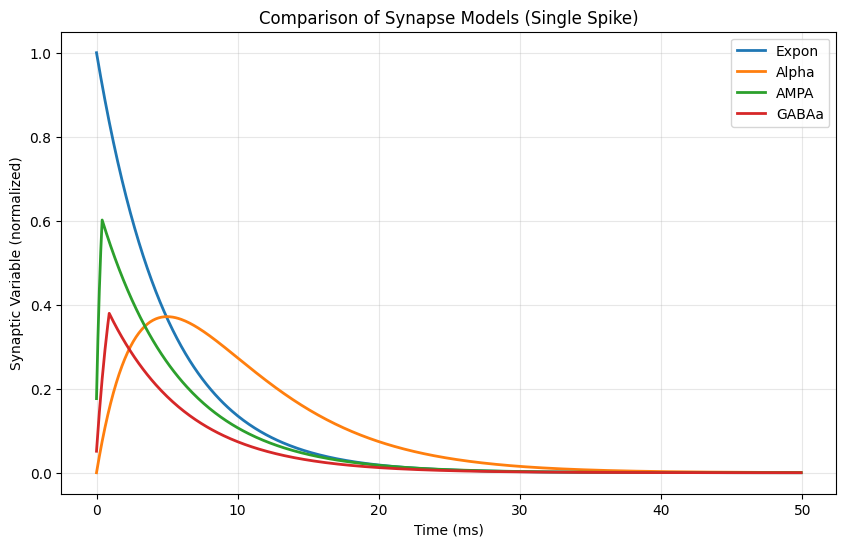

In [18]:
# Set simulation timestep
brainstate.environ.set(dt=0.1 * u.ms)

# Create different synapses (without unit initializers to avoid mismatch)
expon = brainpy.state.Expon(1, tau=5 * u.ms)
alpha = brainpy.state.Alpha(1, tau=5 * u.ms)
ampa = brainpy.state.AMPA(1, T=2 * u.mM)
gaba = brainpy.state.GABAa(1, T=1. * u.mM)

# Initialize
for syn in [expon, alpha, ampa, gaba]:
    brainstate.nn.init_all_states(syn)

# Single spike at t=0 (dimensionless spike count)
spike_input = jnp.zeros(100) * u.mS
spike_input = spike_input.at[0].set(1.0 * u.mS)

# Simulate
times = u.math.arange(0 * u.ms, 50 * u.ms, 0.1 * u.ms)
responses = {
    'Expon': [],
    'Alpha': [],
    'AMPA': [],
    'GABAa': []
}

for syn, name in zip([expon, alpha], ['Expon', 'Alpha']):
    brainstate.nn.init_all_states(syn)


    def step_run(i, t):
        with brainstate.environ.context(t=t, i=i):
            inp = u.math.where(i == 0, 1.0 * u.mS, 0.0 * u.mS)
            g_val = syn(inp)
        return g_val


    responses[name] = brainstate.transform.for_loop(
        step_run, u.math.arange(times.size), times,
    )

for syn, name in zip([ampa, gaba], ['AMPA', 'GABAa']):
    brainstate.nn.init_all_states(syn)


    def step_run(i, t):
        with brainstate.environ.context(t=t, i=i):
            inp = u.math.where(i == 0, 1.0, 0.0)
            g_val = syn(inp)
        return g_val


    responses[name] = brainstate.transform.for_loop(
        step_run, u.math.arange(times.size), times,
    )

# Plot
plt.figure(figsize=(10, 6))
for name, response in responses.items():
    plt.plot(times, response, label=name, linewidth=2)

plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Variable (normalized)')
plt.title('Comparison of Synapse Models (Single Spike)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()